<a href="https://colab.research.google.com/github/Marwa-Chouhdary/Data-Science-Projects/blob/main/Churn_Prediction_for_a_Telecom_Company.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction for a Telecom Company

#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


#Load & Clean Data

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = df.copy()

# Remove whitespace from headers
df.columns = df.columns.str.strip()

# Handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customerID
df.drop('customerID', axis=1, inplace=True)


/tmp/ipython-input-2-707272875.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


#EDA

Text(0.5, 1.0, 'Churn Distribution')

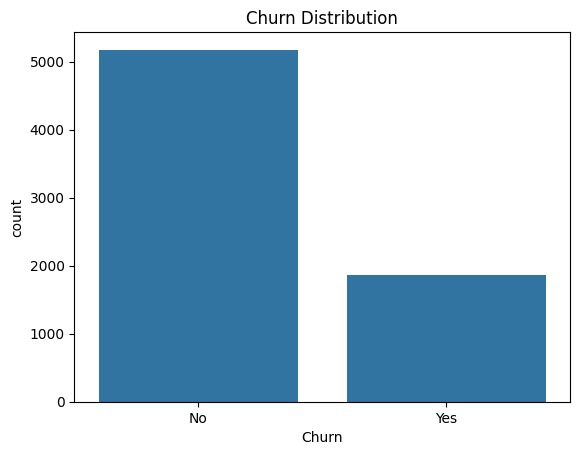

In [3]:
# Churn distribution
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')

Text(0.5, 1.0, 'Contract Type vs Churn')

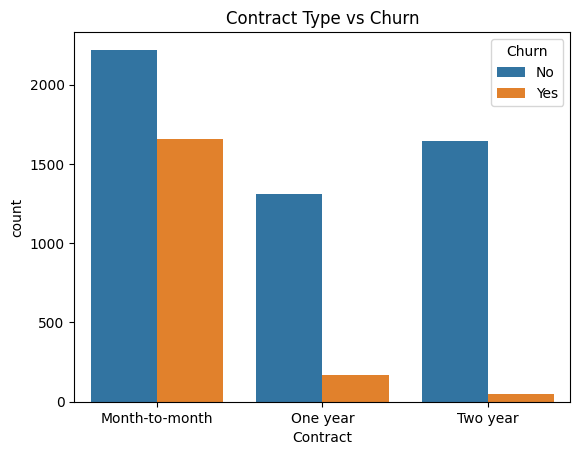

In [4]:
# Contract type vs churn
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Contract Type vs Churn')

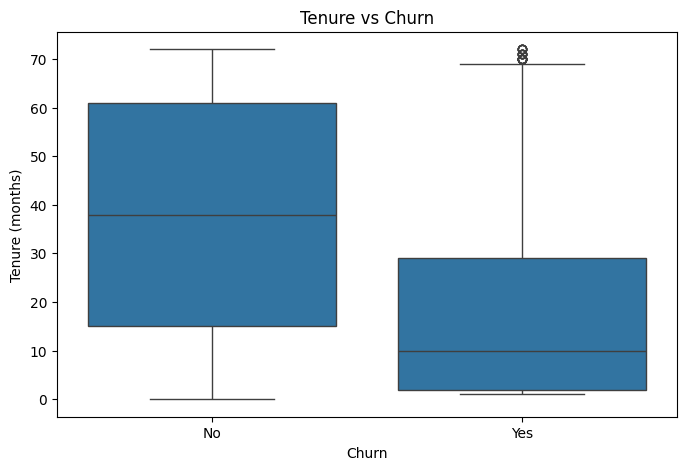

In [5]:
#Tenure vs Churn (Boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Churn', y='tenure')
plt.title('Tenure vs Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (months)')
plt.show()


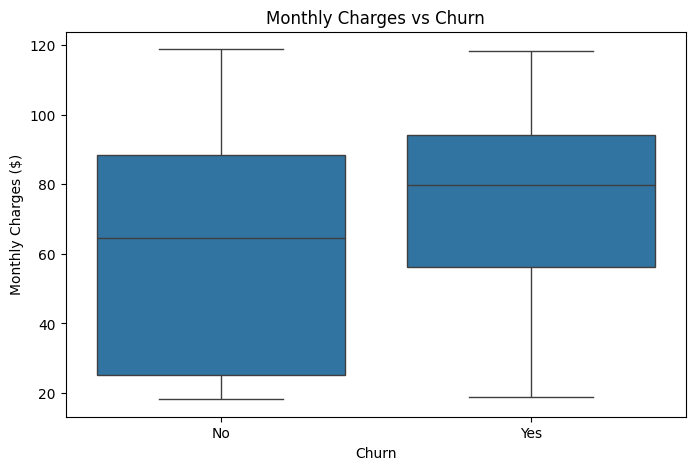

In [6]:
# MonthlyCharges vs Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.title('Monthly Charges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges ($)')
plt.show()


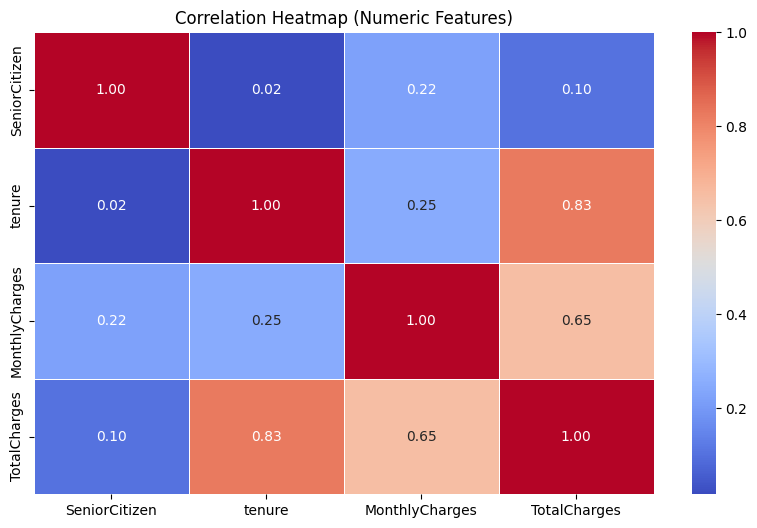

In [7]:
# Correlation Heatmap (Numeric Features)
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Compute correlation
corr = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()


#Encoding Categorical Features

In [8]:
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
df[binary_cols] = df[binary_cols].apply(lambda x: LabelEncoder().fit_transform(x))

df = pd.get_dummies(df, drop_first=True)  # For multi-class categorical


#Train/Test Split

In [9]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


#Handle Class Imbalance: SMOTE

In [10]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


#Feature Scaling

In [11]:
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)


#Train Models

##Logistic Regression

In [12]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_sm, y_train_sm)
y_pred_lr = lr.predict(X_test)


##Random Forest

In [13]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_sm, y_train_sm)
y_pred_rf = rf.predict(X_test)


##XGBoost

In [14]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_sm, y_train_sm)
y_pred_xgb = xgb.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:35:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#Evaluation

In [15]:
models = {'Logistic Regression': y_pred_lr, 'Random Forest': y_pred_rf, 'XGBoost': y_pred_xgb}

for name, preds in models.items():
    print(f"--- {name} ---")
    print(classification_report(y_test, preds))
    print(f"AUC Score: {roc_auc_score(y_test, preds):.4f}")


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1035
           1       0.53      0.64      0.58       374

    accuracy                           0.75      1409
   macro avg       0.69      0.72      0.70      1409
weighted avg       0.77      0.75      0.76      1409

AUC Score: 0.7169
--- Random Forest ---
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1035
           1       0.57      0.59      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.72      0.71      1409
weighted avg       0.78      0.77      0.77      1409

AUC Score: 0.7151
--- XGBoost ---
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1035
           1       0.56      0.60      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71   

#Feature Importance (for XGBoost or RF)

Text(0.5, 1.0, 'Top 10 Feature Importances')

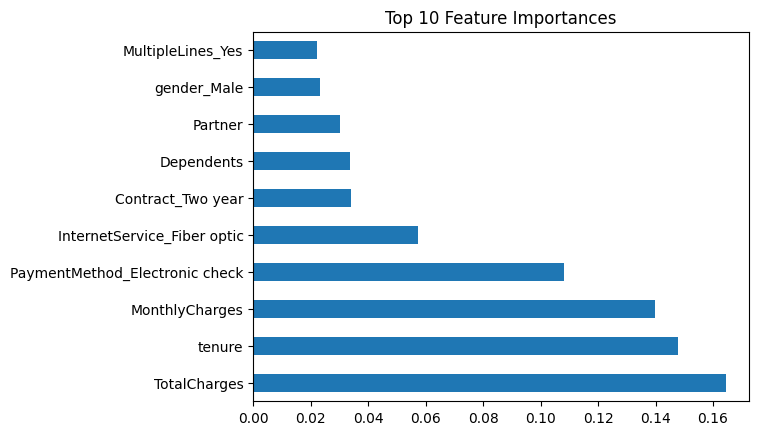

In [16]:
# For Random Forest
importances = rf.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
feat_imp[:10].plot(kind='barh')
plt.title('Top 10 Feature Importances')
